# **Student Performance Analysis**

### Team Members: Trishaun Blake, Michael Eiger, Naquan Smith, and Jayla Williams
### Emails: Tblake36@gatech.edu, Meiger3@gatech.edu, Nsmith363@gatech.edu, and Jwilliams664@gatech.edu

# **Importing the Necessary Packages and Configuring Settings**

In [ ]:
# Installing the aif360 package for use within the Jupyter Notebook environment
  # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023d)
%pip install aif360
  # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023d)

In [ ]:
# Importing packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid') # Setting default visualization style
import pandas as pd
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Create a figures folder to hold images
	# START REFERENCE TO Python Software Foundation (2023)
if 'figures' not in os.listdir():
	os.makedirs('./figures')
  # END REFERENCE TO Python Software Foundation (2023)

# **Step 1:**

### **1.1.   Selected Dataset**

We chose the "Student Performance Data Set" (SPDS) dataset, which is publicly available through Kaggle’s dataset repository (Cortez, 2019). At a high level,
the dataset’s features cumulatively reflect each subject’s demography and social background. Each subject’s record within the dataset also
contains variables conveying characteristics about their school and the grades
they received in a Portuguese language class within certain periods. Of note,
the dataset’s description on Kaggle shows that it was initially comprised of two
sub-datasets - one about students in the Portuguese language class and another
about students in a Math class (Cortez, 2019). The following analysis only relates to the Portuguese language class portion of the dataset, as this was the only sub-dataset found on Kaggle.

In [ ]:
# Reading the SPDS dataset into dataframe & displaying several rows
df = pd.read_csv('./student-por.csv')
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


### **1.2 Regulated Domain**

Among other features, each record within the SPDS dataset conveys relevant
data about one Portuguese school student’s (i.e., one subject’s) earned grades
(Cortez, 2019). Given this student-centric data, the dataset can be said to belong to the Regulated Domain of Education.

### **1.3 Count of Observations and Variables**

The SPDS dataset contains 649 observations, with each observation pertaining to
data obtained from one Portuguese school student (Cortez, 2019). Furthermore, each observation encompasses 33 variables that collectively convey information about each subject’s demographics, social background, school characteristics, and grades.

In [ ]:
print('Number of observations in the SPDS dataset: ' + str(df.shape[0]))
print('Number of variables in the SPDS dataset: ' + str(df.shape[1]))

Number of observations in the SPDS dataset: 649
Number of variables in the SPDS dataset: 33


### **1.4 Dependent Variables**

Of the 33 variables available in the SPDS dataset, three were selected for use
as dependent variables - "G1", "G2", and "G3" (Cortez, 2019). Each dependent variable is a quantitative, continuous variable that reflects a student’s grade after a particular school year period (first, second, or third). Specifically, G1 represents a subject’s grade after the first period of the school year, G2 represents a subject’s grade after the second period of the school year, and G3 represents a subject’s grade after the third (and final) period of the school year.

In [ ]:
# Displaying the top few rows of the selected dependent variables (G1, G2, and G3)
df[['G1','G2','G3']].head(5)

,G1,G2,G3
0,0,11,11
1,9,11,11
2,12,13,12
3,14,14,14
4,11,13,13


### **1.5 Protected Class Variables**

Four variables in the SPDS dataset appear to pertain to a protected class that is legally protected (Cortez, 2019). The specific variables, relevant protected class, and associated laws or legal precedents are displayed below in "Table 1".


> Table 1 — A table communicating the legally recognized protected class variables found within the SPDS dataset and their associated
legal precedent(s)/law(s).

In [ ]:
# Recreating "Table 1" from the report, which displays the legally recognized
# protected class variables from the dataset
table_1 = pd.DataFrame(data={})
table_1['Dataset Variable'] = ["age","famsize","Pstatus","sex"]
table_1['Protected Class'] = ["Age","Familial Status","Familial Status","Sex"]
table_1['Associated Law(s)/Legal Precedent(s)'] = ["Age Discrimination in Employment Act of 1967",
                                           "Civil Rights Act of 1968",
                                           "Civil Rights Act of 1968",
                                           "Equal Pay Act of 1963; Civil Rights Act of 1964, 1991"]

table_1.loc[:,'Dataset Variable':'Associated Law(s)/Legal Precedent(s)']

,Dataset Variable,Protected Class,Associated Law(s)/Legal Precedent(s)
0,age,Age,Age Discrimination in Employment Act of 1967
1,famsize,Familial Status,Civil Rights Act of 1968
2,Pstatus,Familial Status,Civil Rights Act of 1968
3,sex,Sex,Equal Pay Act of 1963; Civil Rights Act of 196...


# **Step 2:**

### **2.1 Members Associated with Protected Class Variables**

In [ ]:
# Members associated with the 'age' protected class variable
age_grouped = pd.DataFrame({
    'Age': [15,16,17,18,19,20,21,22],
    'Count': df['age'].value_counts().sort_index(ascending=True)
})

# Combining groups to create subsets of membership categories
age_grouped['Age'] = age_grouped['Age'].map({15:'15-16',16:'15-16',
                                             17:'17-18',18:'17-18',
                                             19:'19+',20:'19+',21:'19+',22:'19+'})
age_grouped = age_grouped.groupby('Age').sum()
print(list(age_grouped.index))

['15-16', '17-18', '19+']


In [ ]:
# Members associated with the 'famsize' protected class variable
print(list(df['famsize'].value_counts().sort_index(ascending=True).index))

['GT3', 'LE3']


In [ ]:
# Members associated with the 'Pstatus' protected class variable
print(list(df['Pstatus'].value_counts().sort_index(ascending=True).index))

['A', 'T']


In [ ]:
# Members associated with the 'sex' protected class variable
print(list(df['sex'].value_counts().sort_index(ascending=True).index))

['F', 'M']


### **2.2 Relationship Between Values and Discretized Variables**

In [ ]:
# Clarifying the frequency of values for the "G1" dependent variable
df['G1'].value_counts().sort_index(ascending=True)

0      1
4      2
5      5
6      9
7     33
8     42
9     65
10    95
11    91
12    82
13    72
14    71
15    35
16    22
17    16
18     7
19     1
Name: G1, dtype: int64

In [ ]:
# Discretizing the "G1" dependent variable based on possible variable values
df['G1_disc'] = df['G1'].map({0:'0-5', 4:'0-5', 5:'0-5',
                             6: '6-10', 7: '6-10', 8: '6-10', 9: '6-10', 10: '6-10',
                             11: '11-15', 12: '11-15', 13: '11-15', 14: '11-15', 15: '11-15',
                             16: '16-19', 17: '16-19', 18: '16-19', 19: '16-19'})
df['G1_disc'].value_counts().sort_index(ascending=True)

0-5        8
11-15    351
16-19     46
6-10     244
Name: G1_disc, dtype: int64

In [ ]:
# Clarifying the frequency of values for the "G2" dependent variable
df['G2'].value_counts().sort_index(ascending=True)

0       7
5       3
6       7
7      16
8      40
9      72
10     83
11    103
12     86
13     80
14     54
15     38
16     25
17     20
18     14
19      1
Name: G2, dtype: int64

In [ ]:
# Discretizing the "G2" dependent variable based on possible variable values
df['G2_disc'] = df['G2'].map({0:'0-5', 5:'0-5',
                             6: '6-10', 7: '6-10', 8: '6-10', 9: '6-10', 10: '6-10',
                             11: '11-15', 12: '11-15', 13: '11-15', 14: '11-15', 15: '11-15',
                             16: '16-19', 17: '16-19', 18: '16-19', 19: '16-19'})
df['G2_disc'].value_counts().sort_index(ascending=True)

0-5       10
11-15    361
16-19     60
6-10     218
Name: G2_disc, dtype: int64

In [ ]:
# Clarifying the frequency of values for the "G3" dependent variable
df['G3'].value_counts().sort_index(ascending=True)

0      15
1       1
5       1
6       3
7      10
8      35
9      35
10     97
11    104
12     72
13     82
14     63
15     49
16     36
17     29
18     15
19      2
Name: G3, dtype: int64

In [ ]:
# Discretizing the "G3" dependent variable based on possible variable values
df['G3_disc'] = df['G3'].map({0:'0-5', 1:'0-5', 5:'0-5',
                             6: '6-10', 7: '6-10', 8: '6-10', 9: '6-10', 10: '6-10',
                             11: '11-15', 12: '11-15', 13: '11-15', 14: '11-15', 15: '11-15',
                             16: '16-19', 17: '16-19', 18: '16-19', 19: '16-19'})
df['G3_disc'].value_counts().sort_index(ascending=True)

0-5       17
11-15    370
16-19     82
6-10     180
Name: G3_disc, dtype: int64

### **2.3 Protected Class Variable Frequency**

In [ ]:
# Frequency for each member associated with the 'age' protected class variable
age_grouped = pd.DataFrame({
    'Age': [15,16,17,18,19,20,21,22],
    'Count': df['age'].value_counts().sort_index(ascending=True)
})
age_grouped['Age'] = age_grouped['Age'].map({15:'15-16',16:'15-16',17:'17-18',18:'17-18',19:'19+',20:'19+',21:'19+',22:'19+'})
age_grouped = age_grouped.groupby('Age').sum()
print(age_grouped)

       Count
Age         
15-16    289
17-18    319
19+       41


In [ ]:
# Frequency for each member associated with the 'famsize' protected class variable
df['famsize'].value_counts().sort_index(ascending=True)

GT3    457
LE3    192
Name: famsize, dtype: int64

In [ ]:
# Frequency for each member associated with the 'Pstatus' protected class variable
df['Pstatus'].value_counts().sort_index(ascending=True)

A     80
T    569
Name: Pstatus, dtype: int64

In [ ]:
# Frequency for each member associated with the 'sex' protected class variable
df['sex'].value_counts().sort_index(ascending=True)

F    383
M    266
Name: sex, dtype: int64

### **2.4 Protected Class Histograms**

##### 2.4.1 Histograms for "age"

###### G1 ("age")

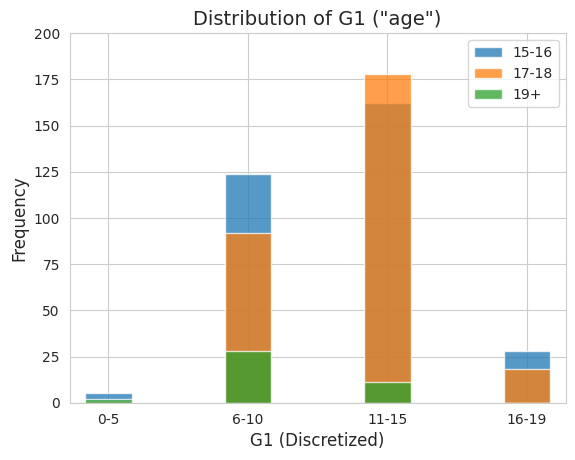

In [ ]:
age = df.copy()
age['age_grouped'] = age['age'].map({15:'15-16',16:'15-16',17:'17-18',18:'17-18',19:'19+',20:'19+',21:'19+',22:'19+'})
  # START REFERENCE TO Yuca (2018)
age['G1_age_sort'] = age['G1_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
age['G2_age_sort'] = age['G2_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
age['G3_age_sort'] = age['G3_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
  # END REFERENCE TO Yuca (2018)

# G1 Histogram for "age"
plt.hist(age[age['age_grouped']=='17-18']['G1_disc'],label='17-18',alpha=0.75)
plt.hist(age[age['age_grouped']=='15-16']['G1_disc'],label='15-16',alpha=0.75)
  # START REFERENCE TO The Matplotlib Development Team (2023b)
plt.hist(age[age['age_grouped']=='19+']['G1_disc'],label='19+',alpha=0.75,range=('0-5','16-19'))
  # END REFERENCE TO The Matplotlib Development Team (2023b)
plt.title('Distribution of G1 ("age")',fontsize=14)
plt.xlabel('G1 (Discretized)',fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,225,25))
plt.ylabel('Frequency',fontsize=12)
plt.legend(['15-16','17-18','19+'])
plt.savefig('./figures/G1_age_histogram.jpg')
plt.show()

###### G2 ("age")

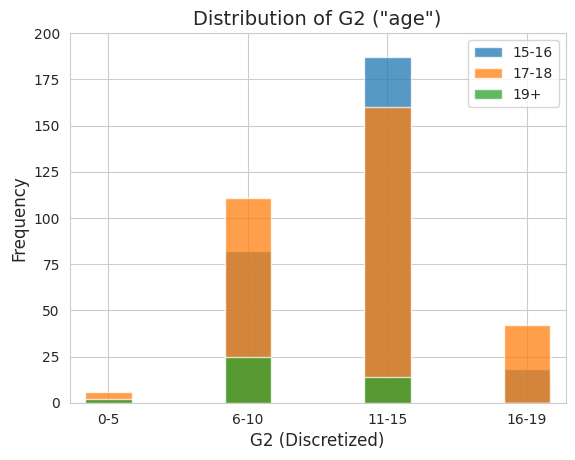

In [ ]:
# G2 Histogram for "age"
  # START REFERENCE TO Yuca (2018)
plt.hist(age[age['age_grouped']=='15-16'].sort_values('G2_age_sort')['G2_disc'],label='15-16',alpha=0.75)
plt.hist(age[age['age_grouped']=='17-18'].sort_values('G2_age_sort')['G2_disc'],label='17-18',alpha=0.75)
  # START REFERENCE TO The Matplotlib Development Team (2023b)
plt.hist(age[age['age_grouped']=='19+'].sort_values('G2_age_sort')['G2_disc'],label='19+',alpha=0.75,range=('0-5','16-19'))
  # END REFERENCE TO Yuca (2018) AND The Matplotlib Development Team (2023b)
plt.title('Distribution of G2 ("age")',fontsize=14)
plt.xlabel('G2 (Discretized)',fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,225,25))
plt.ylabel('Frequency',fontsize=12)
plt.legend(['15-16','17-18','19+'])
plt.savefig('./figures/G2_age_histogram.jpg')
plt.show()

###### G3 ("age")

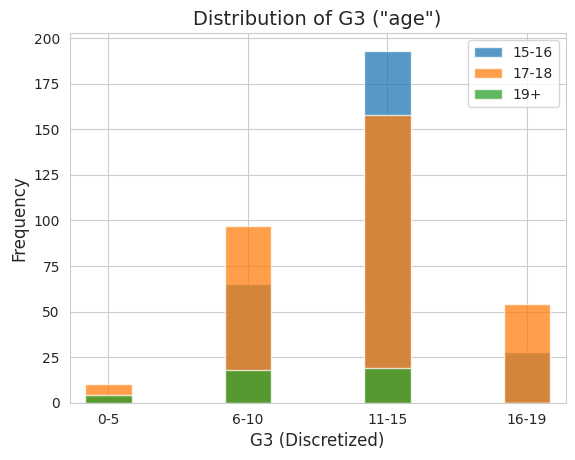

In [ ]:
# G3 Histogram for "age"
  # START REFERENCE TO Yuca (2018)
plt.hist(age[age['age_grouped']=='15-16'].sort_values('G3_age_sort')['G3_disc'],label='15-16',alpha=0.75)
plt.hist(age[age['age_grouped']=='17-18'].sort_values('G3_age_sort')['G3_disc'],label='17-18',alpha=0.75)
  # START REFERENCE TO The Matplotlib Development Team (2023b)
plt.hist(age[age['age_grouped']=='19+'].sort_values('G3_age_sort')['G3_disc'],label='19+',alpha=0.75,range=('0-5','16-19'))
  # END REFERENCE TO Yuca (2018) AND The Matplotlib Development Team (2023b)
plt.title('Distribution of G3 ("age")',fontsize=14)
plt.xlabel('G3 (Discretized)',fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.ylabel('Frequency',fontsize=12)
plt.legend(['15-16','17-18','19+'])
plt.savefig('./figures/G3_age_histogram.jpg')
plt.show()

#### 2.4.2 Histograms for "famsize"

##### G1 ("famsize")

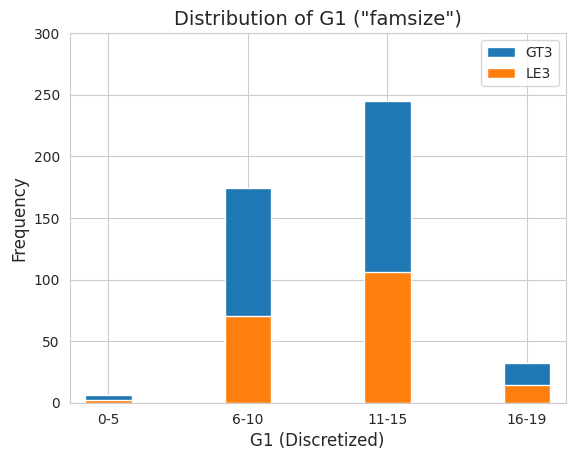

In [ ]:
famsize = df.copy()
  # START REFERENCE TO Yuca (2018)
famsize['G1_famsize_sort'] = famsize['G1_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
famsize['G2_famsize_sort'] = famsize['G2_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
famsize['G3_famsize_sort'] = famsize['G3_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
  # END REFERENCE TO Yuca (2018)

# G1 Histogram for "famsize"
plt.hist(famsize[famsize['famsize']=='GT3']['G1_disc'],label='GT3')
plt.hist(famsize[famsize['famsize']=='LE3']['G1_disc'],label='LE3')
plt.title('Distribution of G1 ("famsize")',fontsize=14)
plt.xlabel('G1 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,350,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G1_famsize_histogram.jpg')
plt.show()

##### G2 ("famsize")

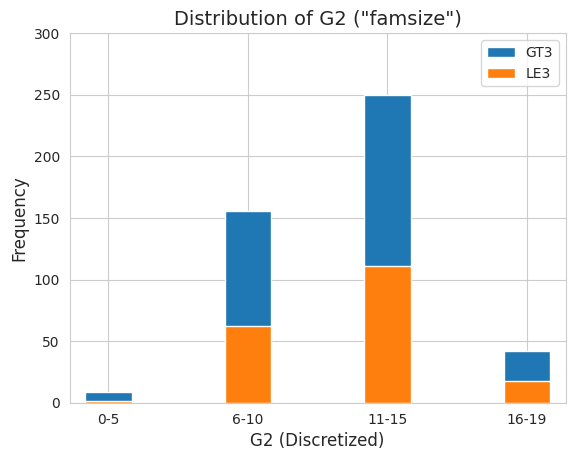

In [ ]:
# G2 Histogram for "famsize"
  # START REFERENCE TO Yuca (2018)
plt.hist(famsize[famsize['famsize']=='GT3'].sort_values('G2_famsize_sort')['G2_disc'],label='GT3')
plt.hist(famsize[famsize['famsize']=='LE3'].sort_values('G2_famsize_sort')['G2_disc'],label='LE3')
  # END REFERENCE TO Yuca (2018)
plt.title('Distribution of G2 ("famsize")',fontsize=14)
plt.xlabel('G2 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,350,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G2_famsize_histogram.jpg')
plt.show()

##### G3 ("famsize")

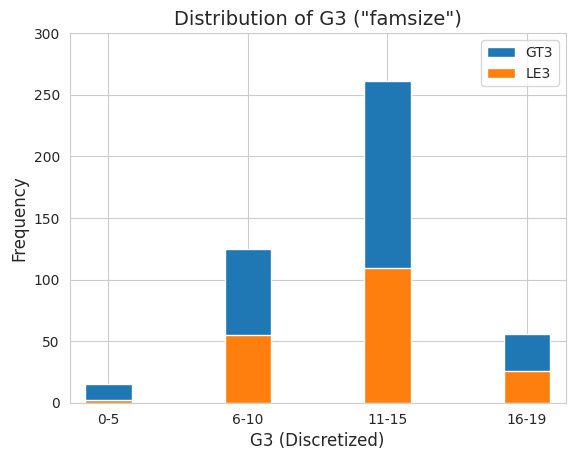

In [ ]:
# G3 Histogram for "famsize"
  # START REFERENCE TO Yuca (2018)
plt.hist(famsize[famsize['famsize']=='GT3'].sort_values('G3_famsize_sort')['G3_disc'],label='GT3')
plt.hist(famsize[famsize['famsize']=='LE3'].sort_values('G3_famsize_sort')['G3_disc'],label='LE3')
  # END REFERENCE TO Yuca (2018)
plt.title('Distribution of G3 ("famsize")',fontsize=14)
plt.xlabel('G3 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,350,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G3_famsize_histogram.jpg')
plt.show()

#### 2.4.3 Histograms for "Pstatus"

##### G1 ("Pstatus")

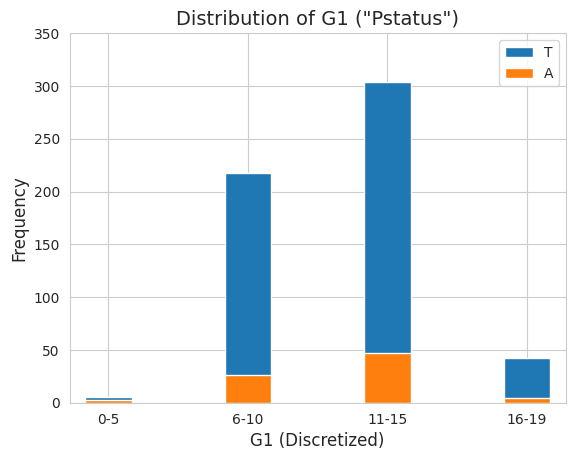

In [ ]:
Pstatus = df.copy()
  # START REFERENCE TO Yuca (2018)
Pstatus['G1_pstatus_sort'] = Pstatus['G1_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
Pstatus['G2_pstatus_sort'] = Pstatus['G2_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
Pstatus['G3_pstatus_sort'] = Pstatus['G3_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
  # END REFERENCE TO Yuca (2018)

# G1 Histogram for "Pstatus"
  # START REFERENCE TO Yuca (2018)
plt.hist(Pstatus[Pstatus['Pstatus']=='T'].sort_values('G1_pstatus_sort')['G1_disc'],label='T')
plt.hist(Pstatus[Pstatus['Pstatus']=='A'].sort_values('G1_pstatus_sort')['G1_disc'],label='A')
  # END REFERENCE TO Yuca (2018)
plt.title('Distribution of G1 ("Pstatus")',fontsize=14)
plt.xlabel('G1 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,400,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G1_Pstatus_histogram.jpg')
plt.show()

##### G2 ("Pstatus")

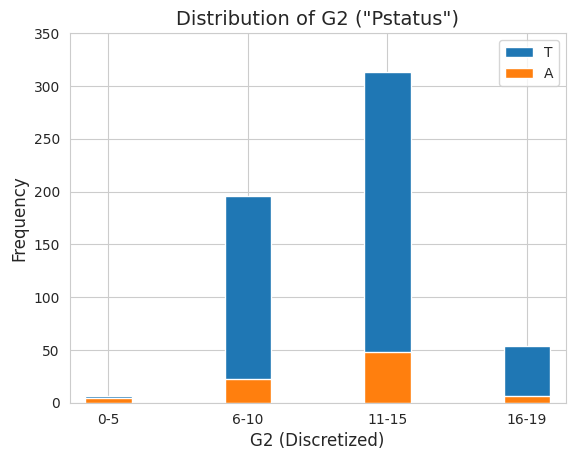

In [ ]:
# G2 Histogram for "Pstatus"
  # START REFERENCE TO Yuca (2018)
plt.hist(Pstatus[Pstatus['Pstatus']=='T'].sort_values('G2_pstatus_sort')['G2_disc'],label='T')
plt.hist(Pstatus[Pstatus['Pstatus']=='A'].sort_values('G2_pstatus_sort')['G2_disc'],label='A')
  # END REFERENCE TO Yuca (2018)
plt.title('Distribution of G2 ("Pstatus")',fontsize=14)
plt.xlabel('G2 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,400,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G2_Pstatus_histogram.jpg')
plt.show()

##### G3 ("Pstatus")

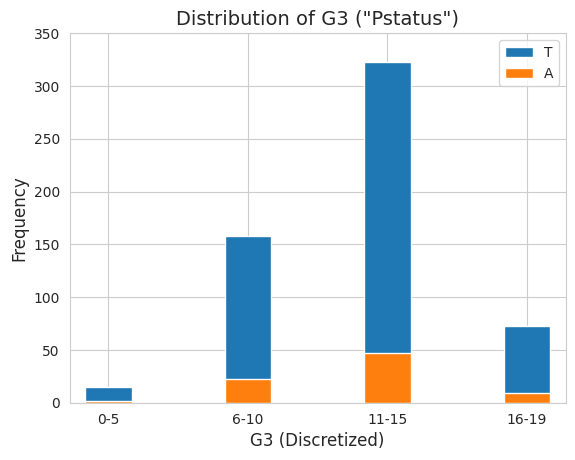

In [ ]:
# G3 Histogram for "Pstatus"
  # START REFERENCE TO Yuca (2018)
plt.hist(Pstatus[Pstatus['Pstatus']=='T'].sort_values('G3_pstatus_sort')['G3_disc'],label='T')
plt.hist(Pstatus[Pstatus['Pstatus']=='A'].sort_values('G3_pstatus_sort')['G3_disc'],label='A')
  # END REFERENCE TO Yuca (2018)
plt.title('Distribution of G3 ("Pstatus")',fontsize=14)
plt.xlabel('G3 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,400,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G3_Pstatus_histogram.jpg')
plt.show()

#### 2.4.4 Histograms for "sex"

##### G1 ("sex")

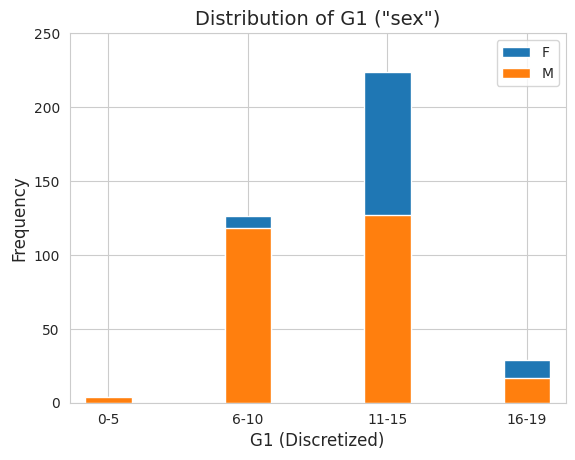

In [ ]:
sex = df.copy()
  # START REFERENCE TO Yuca (2018)
sex['G1_sex_sort'] = sex['G1_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
sex['G2_sex_sort'] = sex['G2_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
sex['G3_sex_sort'] = sex['G3_disc'].map({'0-5':1,'6-10':2,'11-15':3,'16-19':4})
  # END REFERENCE TO Yuca (2018)

# G1 Histogram for "sex"
plt.hist(sex[sex['sex']=='F']['G1_disc'],label='F')
plt.hist(sex[sex['sex']=='M']['G1_disc'],label='M')
plt.title('Distribution of G1 ("sex")',fontsize=14)
plt.xlabel('G1 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,300,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G1_sex_histogram.jpg')
plt.show()

##### G2 ("sex")

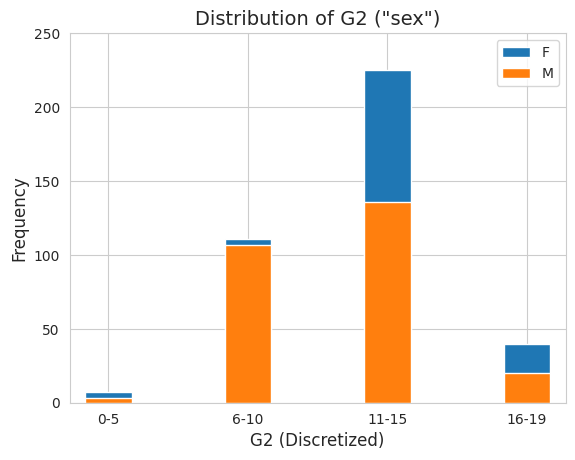

In [ ]:
# G2 Histogram for "sex"
  # START REFERENCE TO Yuca (2018)
plt.hist(sex[sex['sex']=='F'].sort_values('G2_sex_sort')['G2_disc'],label='F')
plt.hist(sex[sex['sex']=='M'].sort_values('G2_sex_sort')['G2_disc'],label='M')
  # END REFERENCE TO Yuca (2018)
plt.title('Distribution of G2 ("sex")',fontsize=14)
plt.xlabel('G2 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,300,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G2_sex_histogram.jpg')
plt.show()

##### G3 ("sex")

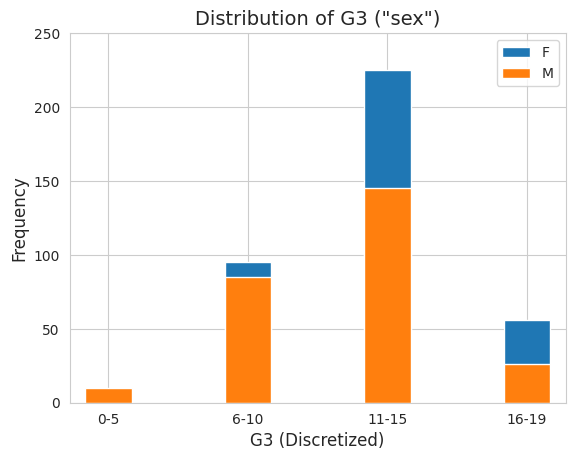

In [ ]:
# G3 Histogram for "sex"
  # START REFERENCE TO Yuca (2018)
plt.hist(sex[sex['sex']=='F'].sort_values('G3_sex_sort')['G3_disc'],label='F')
plt.hist(sex[sex['sex']=='M'].sort_values('G3_sex_sort')['G3_disc'],label='M')
  # END REFERENCE TO Yuca (2018)
plt.title('Distribution of G3 ("sex")',fontsize=14)
plt.xlabel('G3 (Discretized)', fontsize=12)
plt.xlim([-0.1,3.1])
plt.xticks(ticks=[0.15,1.05,1.95,2.85],fontsize=10)
plt.yticks(ticks=range(0,300,50))
plt.ylabel('Frequency',fontsize=12)
plt.legend()
plt.savefig('./figures/G3_sex_histogram.jpg')
plt.show()

# **Step 3:**

### 3.1 Identifying Privileged/Unprivileged Groups

In [ ]:
privileged_unprivileged = pd.DataFrame({})
privileged_unprivileged['Protected Class'] = ["age", "famsize", "Pstatus", "sex"]
privileged_unprivileged['Privileged Group'] = ["15-18", "LE3", "T", "Male"]
privileged_unprivileged['Unprivileged Group'] = ["19+", "GT3", "A", "Female"]
privileged_unprivileged.head(5)

,Protected Class,Privileged Group,Unprivileged Group
0,age,15-18,19+
1,famsize,LE3,GT3
2,Pstatus,T,A
3,sex,Male,Female


### 3.2 Fairness Metrics - Original Dataset

#### Preparing to Compute Fairness Metrics

In [ ]:
# Creating a df with columns specific to Step 3
step3_df = pd.DataFrame(data={})
step3_df['age'] = df['age']
df['age_grouped'] = df['age'].map({15:'15-16',16:'15-16', 17:'17-18',18:'17-18', 19:'19+',20:'19+',21:'19+',22:'19+'})
step3_df['age_grouped'] = df['age_grouped']
step3_df['age_binary'] = df['age_grouped'].map({'15-16':'<19', '17-18':'<19', '19+':'>=19'})
step3_df['famsize'] = df['famsize']
step3_df['Pstatus'] = df['Pstatus']
step3_df['sex'] = df['sex']
step3_df['G1'] = df['G1']
step3_df['G2'] = df['G2']
step3_df['G3'] = df['G3']
step3_df['G1_disc'] = df['G1_disc']
step3_df['G2_disc'] = df['G2_disc']
step3_df['G3_disc'] = df['G3_disc']

#### Declaring Favorability Thresholds

In [ ]:
# Implementing a favorability threshold for each dependent variable
  # G1: Favorable = >=11, Unfavorable = <11
  # G2: Favorable = >=11, Unfavorable = <11
  # G3: Favorable = >=11, Unfavorable = <11
step3_df['G1_favorable'] = df['G1_disc'].map({'0-5':0, '6-10':0, '11-15':1, '16-19':1})
step3_df['G2_favorable'] = df['G2_disc'].map({'0-5':0, '6-10':0, '11-15':1, '16-19':1})
step3_df['G3_favorable'] = df['G3_disc'].map({'0-5':0, '6-10':0, '11-15':1, '16-19':1})

#### Calculating Fairness Metrics for the Original Dataset

In [ ]:
# Binarizing categorical values to ensure data-wise compatability with the aif360 library
step3_df_cast = step3_df.copy()
step3_df_cast['age_binary'] = step3_df_cast['age_binary'].map({'>=19':0, '<19':1})
step3_df_cast['famsize'] = step3_df_cast['famsize'].map({'GT3':0, 'LE3':1})
step3_df_cast['Pstatus'] = step3_df_cast['Pstatus'].map({'A':0, 'T':1})
step3_df_cast['sex'] = step3_df_cast['sex'].map({'F':0, 'M':1})

# Creating a pandas dataframe/dictionaries to store the fairness metrics
step3_2_results = pd.DataFrame(data={})
step3_2_results['Protected Class'] = ['age','famsize','Pstatus','sex']
step3_2_results['Privileged Group'] = ['<19', 'LE3', 'T', 'M']
step3_2_results['Unprivileged Group'] = ['>=19', 'GT3', 'A', 'F']
disparate_impacts = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                     ,'famsize': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                     ,'Pstatus': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                     ,'sex': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}
statistical_parity_differences = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                                  ,'famsize': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                                  ,'Pstatus': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                                  ,'sex': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}

# Creating a structure to store AIF360-processed datasets
original_datasets = {'G1': '', 'G2': '', 'G3': ''}

# Using AIF360 to calculate fairness metrics on the ORIGINAL dataset
for dependent_variable in ['G1_favorable','G2_favorable','G3_favorable']:
  # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)
  step3_df_original = StandardDataset(step3_df_cast
                                      ,label_name=dependent_variable
                                      ,favorable_classes=[1]
                                      ,protected_attribute_names=['age_binary','famsize','Pstatus','sex']
                                      ,privileged_classes=[[1],[1],[1],[1]]
                                      ,features_to_keep = ['age_binary','famsize','Pstatus','sex','G1_favorable','G2_favorable','G3_favorable']
  )
  # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)

  # Storing the StandardDataset for use during later steps
  original_datasets[dependent_variable[0:2]] = step3_df_original

  # Calculating Disparate Impacts and storing the results
  dis_for_table = []
  for protected_class in ['age_binary','famsize','Pstatus','sex']:
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impact = BinaryLabelDatasetMetric(step3_df_original, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).disparate_impact()
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impacts[protected_class.split('_')[0]][dependent_variable] = disparate_impact
    dis_for_table.append(disparate_impact)
  step3_2_results[dependent_variable[0:2] + ' DI'] = dis_for_table

  # Calculating Statistical Parity Differences and storing the results
  sdps_for_table = []
  for protected_class in ['age_binary','famsize','Pstatus','sex']:
      # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_difference = BinaryLabelDatasetMetric(step3_df_original, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).statistical_parity_difference()
      # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_differences[protected_class.split('_')[0]][dependent_variable] = statistical_parity_difference
    sdps_for_table.append(statistical_parity_difference)
  step3_2_results[dependent_variable[0:2] + ' SPD'] = sdps_for_table

# Displaying the fairness metrics for the ORIGINAL dataset
step3_2_results.loc[:,'Protected Class':'G2 SPD'].head(5)

,Protected Class,Privileged Group,Unprivileged Group,G1 DI,G1 SPD,G2 DI,G2 SPD
0,age,<19,>=19,0.422596,-0.366576,0.510098,-0.327944
1,famsize,LE3,GT3,0.969803,-0.018873,0.950995,-0.032925
2,Pstatus,T,A,1.048374,0.029416,1.046526,0.030009
3,sex,M,F,1.220228,0.119221,1.179788,0.105440


### 3.3 & 3.4 Transforming the Original Dataset + Fairness Metrics - Transformed Dataset

In [ ]:
# Creating a pandas dataframe/dictionaries to store the fairness metrics
step3_4_results = pd.DataFrame(data={})
step3_4_results['Protected Class'] = ['age','famsize','Pstatus','sex']
step3_4_results['Privileged Group'] = ['<19', 'LE3', 'T', 'M']
step3_4_results['Unprivileged Group'] = ['>=19', 'GT3', 'A', 'F']
step3_4_results['Pre-Processing Algorithm'] = 'Reweighting'
disparate_impacts_transformed = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                     ,'famsize': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                     ,'Pstatus': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                     ,'sex': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}
statistical_parity_differences_transformed = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                                  ,'famsize': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                                  ,'Pstatus': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}
                                  ,'sex': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}

# Creating a structure to store (Transformed) AIF360-processed datasets
transformed_datasets = {'G1': '', 'G2': '', 'G3': ''}

# Using AIF360 to transform the datasets + calculate fairness metrics on the TRANSFORMED dataset
for dependent_variable in ['G1_favorable','G2_favorable','G3_favorable']:
  # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)
  step3_df_temp = StandardDataset(step3_df_cast
                                  ,label_name=dependent_variable
                                  ,favorable_classes=[1]
                                  ,protected_attribute_names=['age_binary','famsize','Pstatus','sex']
                                  ,privileged_classes=[[1],[1],[1],[1]]
                                  ,features_to_keep = ['age_binary','famsize','Pstatus','sex','G1_favorable','G2_favorable','G3_favorable']
  )
  # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)

  # Performing Reweighting
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023b)
  weights = Reweighing(unprivileged_groups=[{'age_binary':0,'famsize':0,'Pstatus':0,'sex':0}],privileged_groups=[{'age_binary':1,'famsize':1,'Pstatus':1,'sex':1}])
  step3_df_transformed = weights.fit(step3_df_temp).transform(step3_df_temp)
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023b)

  # Storing the (Transformed) StandardDataset for use during later steps
  transformed_datasets[dependent_variable[0:2]] = step3_df_transformed

  # Calculating Disparate Impacts and storing the results
  dis_for_table = []
  for protected_class in ['age_binary','famsize','Pstatus','sex']:
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impact = BinaryLabelDatasetMetric(step3_df_transformed, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).disparate_impact()
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impacts_transformed[protected_class.split('_')[0]][dependent_variable] = disparate_impact
    dis_for_table.append(disparate_impact)
  step3_4_results[dependent_variable[0:2] + ' DI'] = dis_for_table

  # Calculating Statistical Parity Differences and storing the results
  sdps_for_table = []
  for protected_class in ['age_binary','famsize','Pstatus','sex']:
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_difference = BinaryLabelDatasetMetric(step3_df_transformed, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).statistical_parity_difference()
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_differences_transformed[protected_class.split('_')[0]][dependent_variable] = statistical_parity_difference
    sdps_for_table.append(statistical_parity_difference)
  step3_4_results[dependent_variable[0:2] + ' SPD'] = sdps_for_table

# Displaying the fairness metrics for the TRANSFORMED dataset
step3_4_results.loc[:,'Protected Class':'G2 SPD'].head(5)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/reweighing.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/reweighing.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/reweighing.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)


,Protected Class,Privileged Group,Unprivileged Group,Pre-Processing Algorithm,G1 DI,G1 SPD,G2 DI,G2 SPD
0,age,<19,>=19,Reweighting,0.419826,-0.376380,0.513183,-0.329128
1,famsize,LE3,GT3,Reweighting,0.907351,-0.061974,0.923309,-0.053147
2,Pstatus,T,A,Reweighting,1.031321,0.019510,1.043545,0.028397
3,sex,M,F,Reweighting,1.154577,0.088581,1.151835,0.091362


# **Step 4:**

## 4.1 Training/Test Splits - Original Dataset

In [ ]:
# Splitting the ORIGINAL dataset into train/test sets (70-30 split)
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(original_datasets['G1'].convert_to_dataframe()[0].loc[:,'age_binary':'G3_favorable'],
                                                    original_datasets['G1'].convert_to_dataframe()[0].loc[:,'G1_favorable'],
                                                    test_size=0.3, random_state=45)

## 4.2 Training/Test Splits - Transformed Dataset

In [ ]:
# Splitting the TRANSFORMED dataset into train/test sets (70-30 split)
x_train_transformed, x_test_transformed, y_train_transformed, y_test_transformed = train_test_split(transformed_datasets['G1'].convert_to_dataframe()[0].loc[:,'age_binary':'G3_favorable'],
                                                    transformed_datasets['G1'].convert_to_dataframe()[0].loc[:,'G1_favorable'],
                                                    test_size=0.3, random_state=45)

## 4.3 Train a Classifier - Original Training Dataset

In [ ]:
# Training a random forest classifier and making predictions on the TEST set with it
  # START REFERENCE TO scikit-learn developers (2023b)
predictions_original = RandomForestClassifier(random_state=45,n_estimators=100,max_depth=None,criterion='gini').fit(x_train_original, y_train_original).predict(x_test_original)
  # END REFERENCE TO scikit-learn developers (2023b)

# Establishing an Accuracy Rate
  # START REFERENCE TO scikit-learn developers (2023a)
print("Original Dataset Accuracy: " + str(accuracy_score(y_true=y_test_original, y_pred=predictions_original)))
  # END REFERENCE TO scikit-learn developers (2023a)

# Combining the test set features with the classifier's predictions to calculate fairness metrics for the ORIGINAL dataset in Step 4.5
step_4_5_original = x_test_original.copy()
step_4_5_original['G1_favorable'] = predictions_original

Original Dataset Accuracy: 0.8564102564102564


## 4.4 Train a Classifier - Transformed Training Dataset

In [ ]:
# Training a random forest classifier and making predictions on the TEST set with it
  # START REFERENCE TO scikit-learn developers (2023b)
predictions_transformed = RandomForestClassifier(random_state=54,n_estimators=100,max_depth=None,criterion='gini').fit(x_train_transformed, y_train_transformed).predict(x_test_transformed)
  # END REFERENCE TO scikit-learn developers (2023b)

# Establishing an Accuracy Rate
  # START REFERENCE TO scikit-learn developers (2023a)
print("Transformed Dataset Accuracy: " + str(accuracy_score(y_true=y_test_transformed, y_pred=predictions_transformed)))
  # END REFERENCE TO scikit-learn developers (2023a)

# Combining the test set features with the classifier's predictions to calculate fairness metrics for the TRANSFORMED dataset in Step 4.5
step_4_5_transformed = x_test_transformed.copy()
step_4_5_transformed['G1_favorable'] = predictions_transformed

Transformed Dataset Accuracy: 0.8512820512820513


## 4.5 Classifier Fairness Metrics

#### Calculating Fairness Metrics for the Original Dataset (Test Split) Against the Classifier's Predictions

In [ ]:
# Creating a pandas dataframe/dictionaries to store the fairness metrics
step4_5_original_results = pd.DataFrame(data={})
step4_5_original_results['Protected Class'] = ['age']
step4_5_original_results['Privileged Group'] = ['<19']
step4_5_original_results['Unprivileged Group'] = ['>=19']
disparate_impacts = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}
statistical_parity_differences = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}

# Creating a structure to store AIF360-processed datasets
original_datasets_4_5 = {'G1': '', 'G2': '', 'G3': ''}

# Using AIF360 to calculate fairness metrics on the ORIGINAL dataset
for dependent_variable in ['G1_favorable']:
  # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)
  step4_5_df = StandardDataset(step_4_5_original,label_name=dependent_variable
                                                ,favorable_classes=[1]
                                                ,protected_attribute_names=['age_binary']
                                                ,privileged_classes=[[1]]
                                                ,features_to_keep = ['age_binary','G1_favorable','G2_favorable','G3_favorable']
  )
  # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)

  # Storing the StandardDataset for use during later steps
  original_datasets_4_5[dependent_variable[0:2]] = step4_5_df

  # Calculating Disparate Impacts and storing the results
  dis_for_table = []
  for protected_class in ['age_binary']:
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impact = BinaryLabelDatasetMetric(step4_5_df, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).disparate_impact()
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impacts[protected_class.split('_')[0]][dependent_variable] = disparate_impact
    dis_for_table.append(disparate_impact)
  step4_5_original_results[dependent_variable[0:2] + ' DI'] = dis_for_table

  # Calculating Statistical Parity Differences and storing the results
  sdps_for_table = []
  for protected_class in ['age_binary']:
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_difference = BinaryLabelDatasetMetric(step4_5_df, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).statistical_parity_difference()
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_differences[protected_class.split('_')[0]][dependent_variable] = statistical_parity_difference
    sdps_for_table.append(statistical_parity_difference)
  step4_5_original_results[dependent_variable[0:2] + ' SPD'] = sdps_for_table

# Displaying the fairness metrics for the ORIGINAL TESTING dataset
step4_5_original_results.head(1)

,Protected Class,Privileged Group,Unprivileged Group,G1 DI,G1 SPD
0,age,<19,>=19,0.317916,-0.459747


#### Calculating Fairness Metrics for the Transformed Dataset (Test Split) Against the Classifier's Predictions

In [ ]:
# Creating a pandas dataframe/dictionaries to store the fairness metrics
step4_5_transformed_results = pd.DataFrame(data={})
step4_5_transformed_results['Protected Class'] = ['age']
step4_5_transformed_results['Privileged Group'] = ['<19']
step4_5_transformed_results['Unprivileged Group'] = ['>=19']
disparate_impacts = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}
statistical_parity_differences = {'age': {'G1_favorable': 0, 'G2_favorable': 0, 'G3_favorable': 0}}

# Creating a structure to store AIF360-processed datasets
transformed_datasets_4_5 = {'G1': '', 'G2': '', 'G3': ''}

# Using AIF360 to calculate fairness metrics on the TRANSFORMED dataset
for dependent_variable in ['G1_favorable']:
  # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)
  step4_5_df = StandardDataset(step_4_5_transformed,label_name=dependent_variable
                                                ,favorable_classes=[1]
                                                ,protected_attribute_names=['age_binary']
                                                ,privileged_classes=[[1]]
                                                ,features_to_keep = ['age_binary','G1_favorable','G2_favorable','G3_favorable']
  )
  # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023c)

  # Storing the StandardDataset for use during later steps
  transformed_datasets_4_5[dependent_variable[0:2]] = step4_5_df

  # Calculating Disparate Impacts and storing the results
  dis_for_table = []
  for protected_class in ['age_binary']:
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impact = BinaryLabelDatasetMetric(step4_5_df, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).disparate_impact()
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    disparate_impacts[protected_class.split('_')[0]][dependent_variable] = disparate_impact
    dis_for_table.append(disparate_impact)
  step4_5_transformed_results[dependent_variable[0:2] + ' DI'] = dis_for_table

  # Calculating Statistical Parity Differences and storing the results
  sdps_for_table = []
  for protected_class in ['age_binary']:
    # START REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_difference = BinaryLabelDatasetMetric(step4_5_df, unprivileged_groups=[{protected_class:0}], privileged_groups=[{protected_class:1}]).statistical_parity_difference()
    # END REFERENCE TO The AI Fairness 360 (AIF360) Authors (2023a)
    statistical_parity_differences[protected_class.split('_')[0]][dependent_variable] = statistical_parity_difference
    sdps_for_table.append(statistical_parity_difference)
  step4_5_transformed_results[dependent_variable[0:2] + ' SPD'] = sdps_for_table

# Displaying the fairness metrics for the ORIGINAL TESTING dataset
step4_5_transformed_results.head(1)

,Protected Class,Privileged Group,Unprivileged Group,G1 DI,G1 SPD
0,age,<19,>=19,0.320543,-0.454223


## 4.6 Classifier Results Table

Expounded upon in greater detail within the .PDF portion of this submission, the following definitions were used for this step based on Bellamy et al. (2018):
- Positive Change = Disparate Impact moves closer to 1 OR Statistical Parity Difference moves closer to 0 post-transformation/classifier
- Negative Change = Disparate Impact moves further from 1 OR Statistical Parity Difference moves further from 0 post-transformation/classifier
- No Change = Disparate Impact/Statistical Parity Difference does not change at all post-transformation/classifier

(Bellamy et al., 2018, p. 16)

> Table 8 — A table documenting the differences in the outcomes for the
privileged versus unprivileged group after transforming and classifying the data.

In [ ]:
# Structures to store changes across steps
transformed_metrics = []
classifier_original_metrics = []
classifier_transformed_metrics = []

# Isolating the Disparate Impacts for "age" relative to G1
step3_2_age_di_g1 = step3_2_results.iloc[0,3]
step3_4_age_di_g1 = step3_4_results.iloc[0,4]
step4_5_age_di_g1 = {'G1_original': step4_5_original_results.iloc[0,3], 'G1_transformed': step4_5_transformed_results.iloc[0,3]}

# Determining Positive/Negative Changes in Disparate Impact across steps
count = 0
for di_metric in [step3_4_age_di_g1, step4_5_age_di_g1['G1_original'], step4_5_age_di_g1['G1_transformed']]:
  count+=1
    # START REFERENCE TO Bellamy et al. (2018)
  if abs(1-step3_2_age_di_g1) < abs(1-di_metric):
    change = 'Negative Change'
  elif abs(1-step3_2_age_di_g1) > abs(1-di_metric):
    change = 'Positive Change'
  else:
    change = 'No Change'
    # END REFERENCE TO Bellamy et al. (2018)
  if count == 1:
    transformed_metrics.append(change)
  elif count == 2:
    classifier_original_metrics.append(change)
  else:
    classifier_transformed_metrics.append(change)

# Isolating the Statistical Parity Differences for "age" relative to G1
step3_2_age_spd_g1 = step3_2_results.iloc[0,4]
step3_4_age_spd_g1 = step3_4_results.iloc[0,5]
step4_5_age_spd_g1 = {'G1_original': step4_5_original_results.iloc[0,4], 'G1_transformed': step4_5_transformed_results.iloc[0,4]}

# Determining Positive/Negative Changes in Statistical Parity Difference across steps
count = 0
for spd_metric in [step3_4_age_spd_g1, step4_5_age_spd_g1['G1_original'], step4_5_age_spd_g1['G1_transformed']]:
  count+=1
    # START REFERENCE TO Bellamy et al. (2018)
  if abs(0-step3_2_age_spd_g1) < abs(0-spd_metric):
    change = 'Negative Change'
  elif abs(0-step3_2_age_spd_g1) > abs(0-spd_metric):
    change = 'Positive Change'
  else:
    change = 'No Change'
    # END REFERENCE TO Bellamy et al. (2018)
  if count == 1:
    transformed_metrics.append(change)
  elif count == 2:
    classifier_original_metrics.append(change)
  else:
    classifier_transformed_metrics.append(change)

# Recreating Table 8 from the PDF submission
table_8 = pd.DataFrame(data={})
table_8['Fairness Metric'] = ["Disparate Impact","Statistical Parity Difference"]
table_8['Transformed Dataset Metric'] = transformed_metrics
table_8['Classifier - Original Dataset Metric'] = classifier_original_metrics
table_8['Classifier - Transformed Dataset Metric'] = classifier_transformed_metrics
table_8.loc[:,'Fairness Metric':'Classifier - Transformed Dataset Metric']

,Fairness Metric,Transformed Dataset Metric,Classifier - Original Dataset Metric,Classifier - Transformed Dataset Metric
0,Disparate Impact,Negative Change,Negative Change,Negative Change
1,Statistical Parity Difference,Negative Change,Negative Change,Negative Change


# **Step 5:**

## Members of Project Team

1.   Trishaun Blake
2.   Michael Eiger
3.   Naquan Smith
4.   Jayla Williams

## Plotting Fairness Metrics

### Isolating Fairness Metrics for Plotting

In [ ]:
# Isolating the fairness metrics for "age"
step3_2_age_di = {'G1': step3_2_results.iloc[0,3], 'G2': step3_2_results.iloc[0,5]}
step3_2_age_spd = {'G1': step3_2_results.iloc[0,4], 'G2': step3_2_results.iloc[0,6]}
step3_4_age_di = {'G1': step3_4_results.iloc[0,4], 'G2': step3_4_results.iloc[0,6]}
step3_4_age_spd = {'G1': step3_4_results.iloc[0,5], 'G2': step3_4_results.iloc[0,7]}
step4_5_age_di = {'G1_original': step4_5_original_results.iloc[0,3], 'G1_transformed': step4_5_transformed_results.iloc[0,3]}
step4_5_age_spd = {'G1_original': step4_5_original_results.iloc[0,4], 'G1_transformed': step4_5_transformed_results.iloc[0,4]}

# Isolating the fairness metrics for "famsize"
step3_2_famsize_di = {'G1': step3_2_results.iloc[1,3], 'G2': step3_2_results.iloc[1,5]}
step3_2_famsize_spd = {'G1': step3_2_results.iloc[1,4], 'G2': step3_2_results.iloc[1,6]}
step3_4_famsize_di = {'G1': step3_4_results.iloc[1,4], 'G2': step3_4_results.iloc[1,6]}
step3_4_famsize_spd = {'G1': step3_4_results.iloc[1,5], 'G2': step3_4_results.iloc[1,7]}

# Isolating the fairness metrics for "Pstatus"
step3_2_pstatus_di = {'G1': step3_2_results.iloc[2,3], 'G2': step3_2_results.iloc[2,5]}
step3_2_pstatus_spd = {'G1': step3_2_results.iloc[2,4], 'G2': step3_2_results.iloc[2,6]}
step3_4_pstatus_di = {'G1': step3_4_results.iloc[2,4], 'G2': step3_4_results.iloc[2,6]}
step3_4_pstatus_spd = {'G1': step3_4_results.iloc[2,5], 'G2': step3_4_results.iloc[2,7]}

# Isolating the fairness metrics for "sex"
step3_2_sex_di = {'G1': step3_2_results.iloc[3,3], 'G2': step3_2_results.iloc[3,5]}
step3_2_sex_spd = {'G1': step3_2_results.iloc[3,4], 'G2': step3_2_results.iloc[3,6]}
step3_4_sex_di = {'G1': step3_4_results.iloc[3,4], 'G2': step3_4_results.iloc[3,6]}
step3_4_sex_spd = {'G1': step3_4_results.iloc[3,5], 'G2': step3_4_results.iloc[3,7]}

### Fairness Metric Graphs - "age"

Disparate Impact Graph for "age"

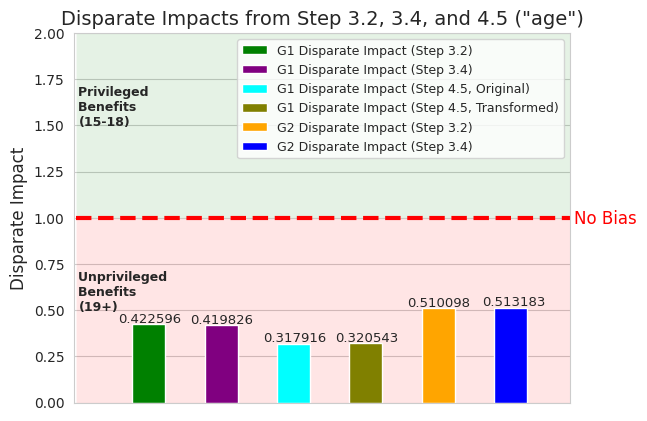

In [ ]:
# Plotting bias regions
plt.barh(y=1.5, width=2.25, height=1, color='green', alpha=0.1)
plt.barh(y=0.5, width=2.25, height=1, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=1.5, s='''Privileged \nBenefits \n(15-18)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=0.5, s='''Unprivileged \nBenefits \n(19+)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32, 1.65, 1.98]
        ,height=[step3_2_age_di['G1'], step3_4_age_di['G1'], step4_5_age_di['G1_original'], step4_5_age_di['G1_transformed'], step3_2_age_di['G2'], step3_4_age_di['G2']]
        ,width=0.15
        ,label=['G1 Disparate Impact (Step 3.2)', 'G1 Disparate Impact (Step 3.4)', 'G1 Disparate Impact (Step 4.5, Original)', 'G1 Disparate Impact (Step 4.5, Transformed)', 'G2 Disparate Impact (Step 3.2)', 'G2 Disparate Impact (Step 3.4)']
            # START REFERENCE TO The Matplotlib Development Team (2023a)
        ,color=['green', 'purple', 'cyan', 'olive', 'orange', 'blue'])
            # END REFERENCE TO The Matplotlib Development Team (2023a)

# Plotting the cutoff between bias regions
plt.plot([0,2.25],[1,1],color='red',linestyle='dashed',linewidth=3)
plt.text(x=2.27,y=0.97,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_age_di['G1'].round(6)), x=0.19, y=step3_2_age_di['G1']+0.01, fontsize=9.5) # Plotting G1 DI (Step 3.2)
plt.text(s=str(step3_4_age_di['G1'].round(6)), x=0.52, y=step3_4_age_di['G1']+0.01, fontsize=9.5) # Plotting G1 DI (Step 3.4)
plt.text(s=str(step4_5_age_di['G1_original'].round(6)), x=0.85, y=step4_5_age_di['G1_original']+0.01, fontsize=9.5) # Plotting G1 DI - Classifier with Original Dataset (Step 4.5)
plt.text(s=str(step4_5_age_di['G1_transformed'].round(6)), x=1.18, y=step4_5_age_di['G1_transformed']+0.01, fontsize=9.5) # Plotting G1 DI - Classifier with Transformed Dataset (Step 4.5)
plt.text(s=str(step3_2_age_di['G2'].round(6)), x=1.51, y=step3_2_age_di['G2']+0.01, fontsize=9.5) # Plotting G2 DI (Step 3.2)
plt.text(s=str(step3_4_age_di['G2'].round(6)), x=1.85, y=step3_4_age_di['G2']+0.01, fontsize=9.5) # Plotting G2 DI (Step 3.4)
plt.title('Disparate Impacts from Step 3.2, 3.4, and 4.5 ("age")', fontsize=14)
plt.xlim([-0.01,2.25])
plt.xticks(ticks=[])
plt.ylim([0,2])
plt.ylabel('Disparate Impact', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_di_age.jpg')
plt.show()

Statistical Parity Difference Graph for "age"

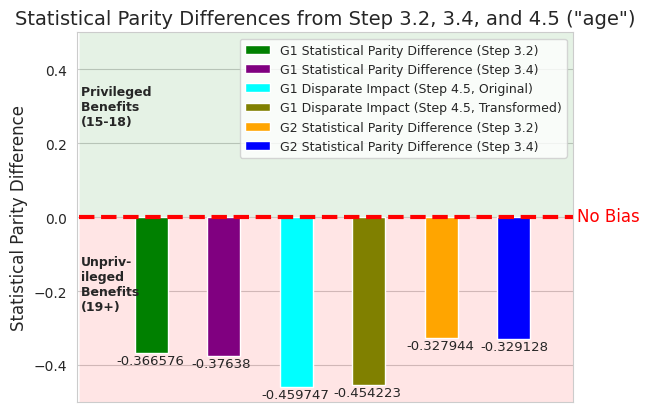

In [ ]:
# Plotting bias regions
plt.barh(y=0.25, width=2.25, height=0.5, color='green', alpha=0.1)
plt.barh(y=-0.25, width=2.25, height=0.5, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=0.25, s='''Privileged \nBenefits \n(15-18)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=-0.25, s='''Unpriv-\nileged \nBenefits \n(19+)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32, 1.65, 1.98]
        ,height=[step3_2_age_spd['G1'], step3_4_age_spd['G1'], step4_5_age_spd['G1_original'], step4_5_age_spd['G1_transformed'], step3_2_age_spd['G2'], step3_4_age_spd['G2']]
        ,width=0.15
        ,label=['G1 Statistical Parity Difference (Step 3.2)', 'G1 Statistical Parity Difference (Step 3.4)', 'G1 Disparate Impact (Step 4.5, Original)', 'G1 Disparate Impact (Step 4.5, Transformed)', 'G2 Statistical Parity Difference (Step 3.2)', 'G2 Statistical Parity Difference (Step 3.4)']
          # START REFERENCE TO The Matplotlib Development Team (2023a)
        ,color=['green', 'purple', 'cyan', 'olive', 'orange', 'blue'])
          # END REFERENCE TO The Matplotlib Development Team (2023a)

# Plotting the cutoff between bias regions
plt.plot([0,2.25],[0,0],color='red',linestyle='dashed',linewidth=3)
plt.text(x=2.27,y=-0.01,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_age_spd['G1'].round(6)), x=0.17, y=step3_2_age_spd['G1']-0.03, fontsize=9.5) # Plotting G1 SPD (Step 3.2)
plt.text(s=str(step3_4_age_spd['G1'].round(6)), x=0.51, y=step3_4_age_spd['G1']-0.03, fontsize=9.5) # Plotting G1 SPD (Step 3.4)
plt.text(s=str(step4_5_age_spd['G1_original'].round(6)), x=0.83, y=step4_5_age_spd['G1_original']-0.03, fontsize=9.5) # Plotting G1 SPD - Classifier with Original Dataset (Step 4.5)
plt.text(s=str(step4_5_age_spd['G1_transformed'].round(6)), x=1.16, y=step4_5_age_spd['G1_transformed']-0.03, fontsize=9.5) # Plotting G1 SPD - Classifier with Transformed Dataset (Step 4.5)
plt.text(s=str(step3_2_age_spd['G2'].round(6)), x=1.49, y=step3_2_age_spd['G2']-0.03, fontsize=9.5) # Plotting G2 SPD (Step 3.2)
plt.text(s=str(step3_4_age_spd['G2'].round(6)), x=1.83, y=step3_4_age_spd['G2']-0.03, fontsize=9.5) # Plotting G2 SPD (Step 3.4)
plt.title('Statistical Parity Differences from Step 3.2, 3.4, and 4.5 ("age")', fontsize=14)
plt.xlim([-0.01,2.25])
plt.xticks(ticks=[])
plt.ylim([-0.5,0.5])
plt.ylabel('Statistical Parity Difference', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_spd_age.jpg')
plt.show()

### Fairness Metric Graphs - "famsize"

Disparate Impact Graph for "famsize"

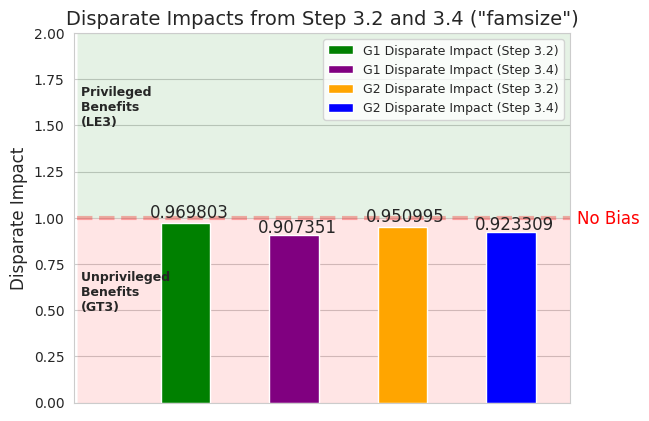

In [ ]:
# Plotting bias regions
plt.barh(y=1.5, width=1.5, height=1, color='green', alpha=0.1)
plt.barh(y=0.5, width=1.5, height=1, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=1.5, s='''Privileged \nBenefits \n(LE3)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=0.5, s='''Unprivileged \nBenefits \n(GT3)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32]
        ,height=[step3_2_famsize_di['G1'], step3_4_famsize_di['G1'], step3_2_famsize_di['G2'], step3_4_famsize_di['G2']]
        ,width=0.15
        ,label=['G1 Disparate Impact (Step 3.2)', 'G1 Disparate Impact (Step 3.4)', 'G2 Disparate Impact (Step 3.2)', 'G2 Disparate Impact (Step 3.4)']
        ,color=['green', 'purple', 'orange', 'blue'])

# Plotting the cutoff between bias regions
plt.plot([0,1.5],[1,1],color='red',linestyle='dashed',linewidth=3,alpha=0.3)
plt.text(x=1.52,y=0.97,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_famsize_di['G1'].round(6)), x=0.22, y=step3_2_famsize_di['G1']+0.03, fontsize=12) # Plotting G1 DI (Step 3.2)
plt.text(s=str(step3_4_famsize_di['G1'].round(6)), x=0.55, y=step3_4_famsize_di['G1']+0.01, fontsize=12) # Plotting G1 DI (Step 3.4)
plt.text(s=str(step3_2_famsize_di['G2'].round(6)), x=0.88, y=step3_2_famsize_di['G2']+0.03, fontsize=12) # Plotting G2 DI (Step 3.2)
plt.text(s=str(step3_4_famsize_di['G2'].round(6)), x=1.21, y=step3_4_famsize_di['G2']+0.01, fontsize=12) # Plotting G2 DI (Step 3.4)
plt.title('Disparate Impacts from Step 3.2 and 3.4 ("famsize")', fontsize=14)
plt.xlim([-0.01,1.5])
plt.xticks(ticks=[])
plt.ylim([0,2])
plt.ylabel('Disparate Impact', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_di_famsize.jpg')
plt.show()

Statistical Parity Difference Graph for "famsize"




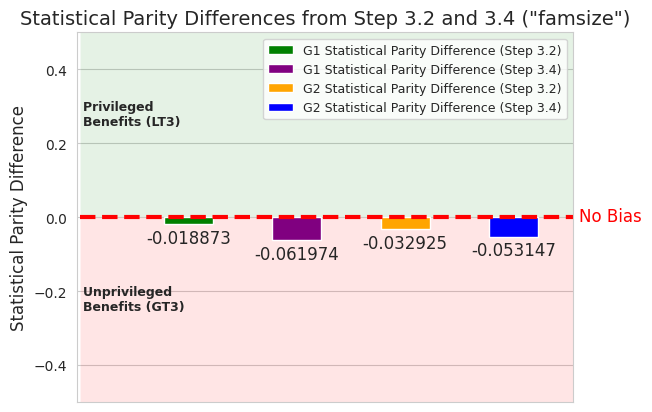

In [ ]:
# Plotting bias regions
plt.barh(y=0.25, width=1.5, height=0.5, color='green', alpha=0.1)
plt.barh(y=-0.25, width=1.5, height=0.5, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=0.25, s='''Privileged \nBenefits (LT3)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=-0.25, s='''Unprivileged \nBenefits (GT3)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32]
        ,height=[step3_2_famsize_spd['G1'], step3_4_famsize_spd['G1'], step3_2_famsize_spd['G2'], step3_4_famsize_spd['G2']]
        ,width=0.15
        ,label=['G1 Statistical Parity Difference (Step 3.2)', 'G1 Statistical Parity Difference (Step 3.4)', 'G2 Statistical Parity Difference (Step 3.2)', 'G2 Statistical Parity Difference (Step 3.4)']
        ,color=['green', 'purple', 'orange', 'blue'])

# Plotting the cutoff between bias regions
plt.plot([0,1.5],[0,0],color='red',linestyle='dashed',linewidth=3)
plt.text(x=1.52,y=-0.01,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_famsize_spd['G1'].round(6)), x=0.2, y=step3_2_famsize_spd['G1']-0.05, fontsize=12) # Plotting G1 SPD (Step 3.2)
plt.text(s=str(step3_4_famsize_spd['G1'].round(6)), x=0.53, y=step3_4_famsize_spd['G1']-0.05, fontsize=12) # Plotting G1 SPD (Step 3.4)
plt.text(s=str(step3_2_famsize_spd['G2'].round(6)), x=0.86, y=step3_2_famsize_spd['G2']-0.05, fontsize=12) # Plotting G2 SPD (Step 3.2)
plt.text(s=str(step3_4_famsize_spd['G2'].round(6)), x=1.19, y=step3_4_famsize_spd['G2']-0.05, fontsize=12) # Plotting G2 SPD (Step 3.4)
plt.title('Statistical Parity Differences from Step 3.2 and 3.4 ("famsize")', fontsize=14)
plt.xlim([-0.01,1.5])
plt.xticks(ticks=[])
plt.ylim([-0.5,0.5])
plt.ylabel('Statistical Parity Difference', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_spd_famsize.jpg')
plt.show()

### Fairness Metric Graphs - "Pstatus"

Disparate Impact Graph for "Pstatus"

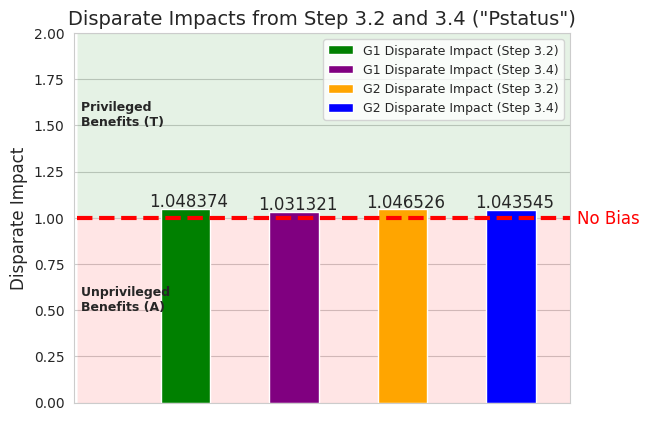

In [ ]:
# Plotting bias regions
plt.barh(y=1.5, width=1.5, height=1, color='green', alpha=0.1)
plt.barh(y=0.5, width=1.5, height=1, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=1.5, s='''Privileged \nBenefits (T)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=0.5, s='''Unprivileged \nBenefits (A)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32]
        ,height=[step3_2_pstatus_di['G1'], step3_4_pstatus_di['G1'], step3_2_pstatus_di['G2'], step3_4_pstatus_di['G2']]
        ,width=0.15
        ,label=['G1 Disparate Impact (Step 3.2)', 'G1 Disparate Impact (Step 3.4)', 'G2 Disparate Impact (Step 3.2)', 'G2 Disparate Impact (Step 3.4)']
        ,color=['green', 'purple', 'orange', 'blue'])

# Plotting the cutoff between bias regions
plt.plot([0,1.5],[1,1],color='red',linestyle='dashed',linewidth=3)
plt.text(x=1.52,y=0.97,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_pstatus_di['G1'].round(6)), x=0.22, y=step3_2_pstatus_di['G1']+0.01, fontsize=12) # Plotting G1 DI (Step 3.2)
plt.text(s=str(step3_4_pstatus_di['G1'].round(6)), x=0.55, y=step3_4_pstatus_di['G1']+0.01, fontsize=12) # Plotting G1 DI (Step 3.4)
plt.text(s=str(step3_2_pstatus_di['G2'].round(6)), x=0.88, y=step3_2_pstatus_di['G2']+0.01, fontsize=12) # Plotting G2 DI (Step 3.2)
plt.text(s=str(step3_4_pstatus_di['G2'].round(6)), x=1.21, y=step3_4_pstatus_di['G2']+0.01, fontsize=12) # Plotting G2 DI (Step 3.4)
plt.title('Disparate Impacts from Step 3.2 and 3.4 ("Pstatus")', fontsize=14)
plt.xlim([-0.01,1.5])
plt.xticks(ticks=[])
plt.ylim([0,2])
plt.ylabel('Disparate Impact', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_di_Pstatus.jpg')
plt.show()

Statistical Parity Difference Graph for "Pstatus"

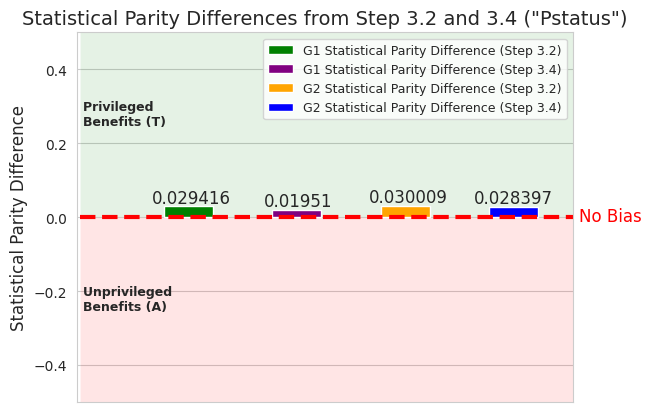

In [ ]:
# Plotting bias regions
plt.barh(y=0.25, width=1.5, height=0.5, color='green', alpha=0.1)
plt.barh(y=-0.25, width=1.5, height=0.5, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=0.25, s='''Privileged \nBenefits (T)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=-0.25, s='''Unprivileged \nBenefits (A)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32]
        ,height=[step3_2_pstatus_spd['G1'], step3_4_pstatus_spd['G1'], step3_2_pstatus_spd['G2'], step3_4_pstatus_spd['G2']]
        ,width=0.15
        ,label=['G1 Statistical Parity Difference (Step 3.2)', 'G1 Statistical Parity Difference (Step 3.4)', 'G2 Statistical Parity Difference (Step 3.2)', 'G2 Statistical Parity Difference (Step 3.4)']
        ,color=['green', 'purple', 'orange', 'blue'])

# Plotting the cutoff between bias regions
plt.plot([0,1.5],[0,0],color='red',linestyle='dashed',linewidth=3)
plt.text(x=1.52,y=-0.01,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_pstatus_spd['G1'].round(6)), x=0.22, y=step3_2_pstatus_spd['G1']+0.01, fontsize=12) # Plotting G1 SPD (Step 3.2)
plt.text(s=str(step3_4_pstatus_spd['G1'].round(6)), x=0.56, y=step3_4_pstatus_spd['G1']+0.01, fontsize=12) # Plotting G1 SPD (Step 3.4)
plt.text(s=str(step3_2_pstatus_spd['G2'].round(6)), x=0.88, y=step3_2_pstatus_spd['G2']+0.01, fontsize=12) # Plotting G2 SPD (Step 3.2)
plt.text(s=str(step3_4_pstatus_spd['G2'].round(6)), x=1.2, y=step3_4_pstatus_spd['G2']+0.01, fontsize=12) # Plotting G2 SPD (Step 3.4)
plt.title('Statistical Parity Differences from Step 3.2 and 3.4 ("Pstatus")', fontsize=14)
plt.xlim([-0.01,1.5])
plt.xticks(ticks=[])
plt.ylim([-0.5,0.5])
plt.ylabel('Statistical Parity Difference', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_spd_Pstatus.jpg')
plt.show()

### Fairness Metric Graphs - "sex"

Disparate Impact Graph for "sex"

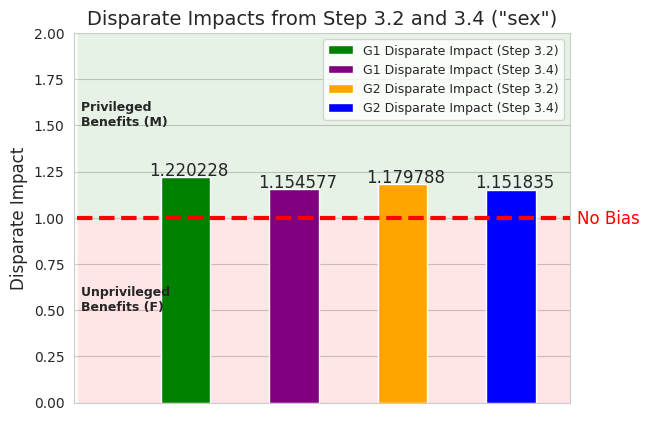

In [ ]:
# Plotting bias regions
plt.barh(y=1.5, width=1.5, height=1, color='green', alpha=0.1)
plt.barh(y=0.5, width=1.5, height=1, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=1.5, s='''Privileged \nBenefits (M)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=0.5, s='''Unprivileged \nBenefits (F)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32]
        ,height=[step3_2_sex_di['G1'], step3_4_sex_di['G1'], step3_2_sex_di['G2'], step3_4_sex_di['G2']]
        ,width=0.15
        ,label=['G1 Disparate Impact (Step 3.2)', 'G1 Disparate Impact (Step 3.4)', 'G2 Disparate Impact (Step 3.2)', 'G2 Disparate Impact (Step 3.4)']
        ,color=['green', 'purple', 'orange', 'blue'])

# Plotting the cutoff between bias regions
plt.plot([0,1.5],[1,1],color='red',linestyle='dashed',linewidth=3)
plt.text(x=1.52,y=0.97,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_sex_di['G1'].round(6)), x=0.22, y=step3_2_sex_di['G1']+0.01, fontsize=12) # Plotting G1 DI (Step 3.2)
plt.text(s=str(step3_4_sex_di['G1'].round(6)), x=0.55, y=step3_4_sex_di['G1']+0.01, fontsize=12) # Plotting G1 DI (Step 3.4)
plt.text(s=str(step3_2_sex_di['G2'].round(6)), x=0.88, y=step3_2_sex_di['G2']+0.01, fontsize=12) # Plotting G2 DI (Step 3.2)
plt.text(s=str(step3_4_sex_di['G2'].round(6)), x=1.21, y=step3_4_sex_di['G2']+0.01, fontsize=12) # Plotting G2 DI (Step 3.4)
plt.title('Disparate Impacts from Step 3.2 and 3.4 ("sex")', fontsize=14)
plt.xlim([-0.01,1.5])
plt.xticks(ticks=[])
plt.ylim([0,2])
plt.ylabel('Disparate Impact', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_di_sex.jpg')
plt.show()

Statistical Parity Difference Graph for "sex"

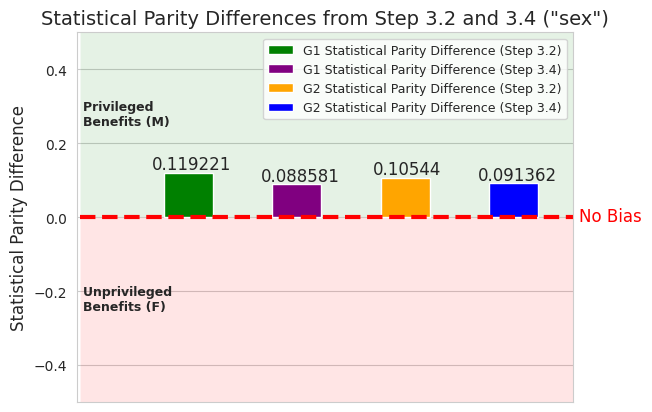

In [ ]:
# Plotting bias regions
plt.barh(y=0.25, width=1.5, height=0.5, color='green', alpha=0.1)
plt.barh(y=-0.25, width=1.5, height=0.5, color='red', alpha=0.1)
  # START REFERENCE TO The Matplotlib Development Team (2023c)
plt.text(x=0.01, y=0.25, s='''Privileged \nBenefits (M)''', fontsize=9, fontweight='bold')
plt.text(x=0.01, y=-0.25, s='''Unprivileged \nBenefits (F)''', fontsize=9, fontweight ='bold')
  # END REFERENCE TO The Matplotlib Development Team (2023c)

# Plotting the fairness metrics
plt.bar(x=[0.33,0.66, 0.99, 1.32]
        ,height=[step3_2_sex_spd['G1'], step3_4_sex_spd['G1'], step3_2_sex_spd['G2'], step3_4_sex_spd['G2']]
        ,width=0.15
        ,label=['G1 Statistical Parity Difference (Step 3.2)', 'G1 Statistical Parity Difference (Step 3.4)', 'G2 Statistical Parity Difference (Step 3.2)', 'G2 Statistical Parity Difference (Step 3.4)']
        ,color=['green', 'purple', 'orange', 'blue'])

# Plotting the cutoff between bias regions
plt.plot([0,1.5],[0,0],color='red',linestyle='dashed',linewidth=3)
plt.text(x=1.52,y=-0.01,s='No Bias',color='red',fontsize=12)

# Plotting/modifying other graph elements
plt.text(s=str(step3_2_sex_spd['G1'].round(6)), x=0.22, y=step3_2_sex_spd['G1']+0.01, fontsize=12) # Plotting G1 SPD (Step 3.2)
plt.text(s=str(step3_4_sex_spd['G1'].round(6)), x=0.55, y=step3_4_sex_spd['G1']+0.01, fontsize=12) # Plotting G1 SPD (Step 3.4)
plt.text(s=str(step3_2_sex_spd['G2'].round(6)), x=0.89, y=step3_2_sex_spd['G2']+0.01, fontsize=12) # Plotting G2 SPD (Step 3.2)
plt.text(s=str(step3_4_sex_spd['G2'].round(6)), x=1.21, y=step3_4_sex_spd['G2']+0.01, fontsize=12) # Plotting G2 SPD (Step 3.4)
plt.title('Statistical Parity Differences from Step 3.2 and 3.4 ("sex")', fontsize=14)
plt.xlim([-0.01,1.5])
plt.xticks(ticks=[])
plt.ylim([-0.5,0.5])
plt.ylabel('Statistical Parity Difference', fontsize=12)
plt.legend(fontsize=9)
plt.savefig('./figures/step5_spd_sex.jpg')
plt.show()

## Which Fairness Metric is Best?

#### Best Fairness Metric - "age"

In [ ]:
# START REFERENCE TO Bellamy et al. (2018)
# Determining the smallest absolute difference amongst fairness metrics for "age" relative to their "No Bias" threshold to determine
# which metric is "best" for this protected class attribute
# Key: DI = Disparate Impact, SPD = Statistical Parity Difference
#      3.2 = Step 3.2, 3.4 = Step 3.4, 4.5 = Step 4.5
step5_3_age = {'G1_DI_3.2': abs(1-step3_2_results.iloc[0,3]), 'G2_DI_3.2': abs(1-step3_2_results.iloc[0,5])
               ,'G1_SPD_3.2': abs(0-step3_2_results.iloc[0,4]), 'G2_SPD_3.2': abs(0-step3_2_results.iloc[0,6])
               ,'G1_DI_3.4': abs(1-step3_4_results.iloc[0,4]), 'G2_DI_3.4': abs(1-step3_4_results.iloc[0,6])
               ,'G1_SPD_3.4': abs(0-step3_4_results.iloc[0,5]), 'G2_SPD_3.4': abs(0-step3_4_results.iloc[0,7])
               ,'G1_original_DI_4.5': abs(1-step4_5_original_results.iloc[0,3]), 'G1_transformed_DI_4.5': abs(1-step4_5_transformed_results.iloc[0,3])
               ,'G1_original_SPD_4.5': abs(0-step4_5_original_results.iloc[0,4]), 'G1_transformed_SPD_4.5': abs(0-step4_5_transformed_results.iloc[0,4])}
# END REFERENCE TO Bellamy et al. (2018)

age_min = {'G1':1000,'G2':1000}
age_min_metric = {'G1': '', 'G2': ''}
for dependent_variable in ['G1','G2']:
  for metric in step5_3_age:
    if metric[0:2] == dependent_variable and step5_3_age[metric] < age_min[dependent_variable]:
      age_min[dependent_variable] = step5_3_age[metric]
      age_min_metric[dependent_variable] = metric

# Printing the results
results = 'The smallest absolute difference amongst fairness metrics for "age": '
for dependent_variable in age_min_metric:
  results = results + ' ' + dependent_variable + ': ' + age_min_metric[dependent_variable].split('_')[1] + '_' + age_min_metric[dependent_variable].split('_')[2] + ' (' + str(age_min[dependent_variable]) + ')'
print(results)

The smallest absolute difference amongst fairness metrics for "age":  G1: SPD_3.2 (0.36657573812580224) G2: SPD_3.2 (0.3279444801026958)


#### Best Fairness Metric - "famsize"

In [ ]:
# START REFERENCE TO Bellamy et al. (2018)
# Determining the smallest absolute difference amongst fairness metrics for "famsize" relative to their "No Bias" threshold to determine
# which metric is "best" for this protected class attribute
# Key: DI = Disparate Impact, SPD = Statistical Parity Difference
#      3.2 = Step 3.2, 3.4 = Step 3.4
step5_3_famsize = {'G1_DI_3.2': abs(1-step3_2_results.iloc[1,3]), 'G2_DI_3.2': abs(1-step3_2_results.iloc[1,5])
               ,'G1_SPD_3.2': abs(0-step3_2_results.iloc[1,4]), 'G2_SPD_3.2': abs(0-step3_2_results.iloc[1,6])
               ,'G1_DI_3.4': abs(1-step3_4_results.iloc[1,4]), 'G2_DI_3.4': abs(1-step3_4_results.iloc[1,6])
               ,'G1_SPD_3.4': abs(0-step3_4_results.iloc[1,5]), 'G2_SPD_3.4': abs(0-step3_4_results.iloc[1,7])
               }
# END REFERENCE TO Bellamy et al. (2018)

famsize_min = {'G1':1000,'G2':1000}
famsize_min_metric = {'G1': '', 'G2': ''}
for dependent_variable in ['G1','G2']:
  for metric in step5_3_famsize:
    if metric[0:2] == dependent_variable and step5_3_famsize[metric] < famsize_min[dependent_variable]:
      famsize_min[dependent_variable] = step5_3_famsize[metric]
      famsize_min_metric[dependent_variable] = metric

# Printing the results
results = 'The smallest absolute difference amongst fairness metrics for "famsize": '
for dependent_variable in famsize_min_metric:
  results = results + ' ' + dependent_variable + ': ' + famsize_min_metric[dependent_variable].split('_')[1] + '_' + famsize_min_metric[dependent_variable].split('_')[2] + ' (' + str(famsize_min[dependent_variable]) + ')'
print(results)

The smallest absolute difference amongst fairness metrics for "famsize":  G1: SPD_3.2 (0.018873085339168538) G2: SPD_3.2 (0.032925328227571105)


#### Best Fairness Metric - "Pstatus"

In [ ]:
# START REFERENCE TO Bellamy et al. (2018)
# Determining the smallest absolute difference amongst fairness metrics for "Pstatus" relative to their "No Bias" threshold to determine
# which metric is "best" for this protected class attribute
# Key: DI = Disparate Impact, SPD = Statistical Parity Difference
#      3.2 = Step 3.2, 3.4 = Step 3.4
step5_3_pstatus = {'G1_DI_3.2': abs(1-step3_2_results.iloc[2,3]), 'G2_DI_3.2': abs(1-step3_2_results.iloc[2,5])
               ,'G1_SPD_3.2': abs(0-step3_2_results.iloc[2,4]), 'G2_SPD_3.2': abs(0-step3_2_results.iloc[2,6])
               ,'G1_DI_3.4': abs(1-step3_4_results.iloc[2,4]), 'G2_DI_3.4': abs(1-step3_4_results.iloc[2,6])
               ,'G1_SPD_3.4': abs(0-step3_4_results.iloc[2,5]), 'G2_SPD_3.4': abs(0-step3_4_results.iloc[2,7])
               }
# END REFERENCE TO Bellamy et al. (2018)

pstatus_min = {'G1':1000,'G2':1000}
pstatus_min_metric = {'G1': '', 'G2': ''}
for dependent_variable in ['G1','G2']:
  for metric in step5_3_pstatus:
    if metric[0:2] == dependent_variable and step5_3_pstatus[metric] < pstatus_min[dependent_variable]:
      pstatus_min[dependent_variable] = step5_3_pstatus[metric]
      pstatus_min_metric[dependent_variable] = metric

# Printing the results
results = 'The smallest absolute difference amongst fairness metrics for "Pstatus": '
for dependent_variable in pstatus_min_metric:
  results = results + ' ' + dependent_variable + ': ' + pstatus_min_metric[dependent_variable].split('_')[1] + '_' + pstatus_min_metric[dependent_variable].split('_')[2] + ' (' + str(pstatus_min[dependent_variable]) + ')'
print(results)

The smallest absolute difference amongst fairness metrics for "Pstatus":  G1: SPD_3.4 (0.019509783962594285) G2: SPD_3.4 (0.028396783978395623)


#### Best Fairness Metric - "sex"

In [ ]:
# START REFERENCE TO Bellamy et al. (2018)
# Determining the smallest absolute difference amongst fairness metrics for "sex" relative to their "No Bias" threshold to determine
# which metric is "best" for this protected class attribute
# Key: DI = Disparate Impact, SPD = Statistical Parity Difference
#      3.2 = Step 3.2, 3.4 = Step 3.4
step5_3_sex = {'G1_DI_3.2': abs(1-step3_2_results.iloc[3,3]), 'G2_DI_3.2': abs(1-step3_2_results.iloc[3,5])
               ,'G1_SPD_3.2': abs(0-step3_2_results.iloc[3,4]), 'G2_SPD_3.2': abs(0-step3_2_results.iloc[3,6])
               ,'G1_DI_3.4': abs(1-step3_4_results.iloc[3,4]), 'G2_DI_3.4': abs(1-step3_4_results.iloc[3,6])
               ,'G1_SPD_3.4': abs(0-step3_4_results.iloc[3,5]), 'G2_SPD_3.4': abs(0-step3_4_results.iloc[3,7])
               }
# END REFERENCE TO Bellamy et al. (2018)

sex_min = {'G1':1000,'G2':1000}
sex_min_metric = {'G1': '', 'G2': ''}
for dependent_variable in ['G1','G2']:
  for metric in step5_3_sex:
    if metric[0:2] == dependent_variable and step5_3_sex[metric] < sex_min[dependent_variable]:
      sex_min[dependent_variable] = step5_3_sex[metric]
      sex_min_metric[dependent_variable] = metric

# Printing the results
results = 'The smallest absolute difference amongst fairness metrics for "sex": '
for dependent_variable in sex_min_metric:
  results = results + ' ' + dependent_variable + ': ' + sex_min_metric[dependent_variable].split('_')[1] + '_' + sex_min_metric[dependent_variable].split('_')[2] + ' (' + str(sex_min[dependent_variable]) + ')'
print(results)

The smallest absolute difference amongst fairness metrics for "sex":  G1: SPD_3.4 (0.08858064004286725) G2: SPD_3.4 (0.09136179473200079)


## Individual Responses

##### Trishaun Blake's Reponse

From the observations seen during the research, both approaches didn’t considerably improved fairness and eliminated bias within the dataset but in comparison to each other, transforming the data through reweighing mitigated more bias. In the protected class of age, reweighing the dataset had an SPD metrics of -0.376380 for grade 1(G1), while the classifier with the original dataset was -0.45974. Both moved the dataset away from the original metrics result of -0.366576 (which is closer to the ideal value of 0), but reweighing gave better results in contrast to the classifier. In my opinion, none of the groups (unprivileged or privileged) is seen benefiting from either approach instead the classifier and reweighing approach disadvantages students aged 19 and older. This may result in older students (aged 19 and older) not being considered for honorary or merit programs within their schools, as each approach has a bias towards them.

##### Michael Eiger's Response

Reweighting often rendered privileged/unprivileged groups for certain protected class attributes (“Pstatus”, “sex”) to have a Disparate Impact that moved closer to 1 and a Statistical Parity Difference that moved closer to 0 for the analyzed dependent variables (G1/G2). Because these respective fairness metric values suggest equality in group benefits and reweighting was the approach most frequently observed to facilitate fairness metrics more suggestive of improved fairness, reweighting was seemingly effective at mitigating bias for these attribute’s groups, albeit to a limited degree (Bellamy et al., p. 16). Due to reweighting and/or using the classifier, instances of Disparate Impact moving further away from a value of 1 and/or Statistical Parity Difference moving further away from a value of 0 in a negative direction provided a *positive advantage* to select privileged groups (e.g., the 15-18 group for the “age” attribute across all steps), as bias favoring such groups was only being reinforced by said approaches. These approaches also *disadvantaged* unprivileged groups (e.g., the 19+ group for the “age” attribute across all steps), as bias against such unprivileged groups was only exacerbated by allowing that same bias to better benefit the associated privileged group. Leveraging the reweighting and/or classifier methods to mitigate bias would cause issues in that they were observed to exacerbate bias in certain protected class attribute groups (e.g., “age”, “famsize”), thus relying on these approaches may undesirably compromise fairness. Furthermore, reweighting negatively impacted the classifier’s predictive accuracy rate on the test set, so attempting to mitigate bias with that approach could hinder prediction integrity.

##### Naquan Smith's Response

Each protected class was affected differently. Some examples negatively affect bias, while others have a positive effect, but Statistical Parity Difference yielded better results than Disparate Impact. There are examples like step 5 di Pstatus for Disparate Impacts from Steps 3.2 and 3.4 ("Pstatus") where we see an improvement and get closer to no bias. However, the Statistical Parity Difference chart shows a smaller number from the no-bias goal line. This should be expected because we cannot obliterate bias, but we took the steps to get closer to it. Removing bias is complicated and a continuous fight. The best way to eliminate bias is through the source/initial contact.

##### Jayla Williams's Response

The only approach that seemed to mitigate bias was the Statistical Parity Difference for sex. It is the only case where a change was seen that fairness was increased to be within the threshold. Surprisingly, it was also the only protected attribute where the bias was against the privileged class. The privileged group, males here a positive advantage. The unprivileged group lost their advantage because the bias against the males decreased. If I were to use Statistical Parity to mitigate bias, it may not consider systemic issues that contribute to the group differences in the first place. As with any bias mitigation methods, issues could arise with trade-offs to accuracy and ethical considerations that differ between data sets.

# References

- Bellamy, Rachel K. E., Dey, Kuntal, Hind, Michael, Hoffman, Samuel C.,
Houde, Stephanie, Kannan, Kalapriya, Lohia, Pranay, Martino, Jacquelyn,
Mehta, Sameep, Mojsilovic, Aleksandra, Nagar, Seema, Ramamurthy, Karth-
ikeyan Natesan, Richards, John, Saha, Diptikalyan, Sattigeri, Prasanna, Singh,
Moninder, Varshney, Kush R., and Zhang, Yunfeng (2018). *AI Fairness 360:
An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwanted
Algorithmic Bias*. arXiv: 1810.01943.

- Cortez, Paulo. (2019). *Student Performance Data Set*. Kaggle. https://www.kaggle.com/datasets/larsen0966/student-performance-data-set/data

- Python Software Foundation. (2023). os - Miscellaneous Operating System Interfaces. Python 3.12.0 Documentation. https://docs.python.org/3/library/os.html

- scikit-learn developers. (2023a). Sklearn.ensemble.accuracy_score. scikit-learn 1.3.2 Documentation. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

- scikit-learn developers. (2023b). Sklearn.ensemble.RandomForestClassifier. scikit-learn 1.3.2 Documentation. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- The AI Fairness 360 (AIF360) Authors. (2023a). *aif360.datasets.BinaryLabelDatasetMetric*. aif360 0.5.0 documentation. https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html

- The AI Fairness 360 (AIF360) Authors. (2023b). *aif360.datasets.Reweighing*. aif360 0.5.0 documentation. https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html

- The AI Fairness 360 (AIF360) Authors. (2023c). *aif360.datasets.StandardDataset*. aif360 0.5.0 documentation. https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.StandardDataset.html

- The AI Fairness 360 (AIF360) Authors. (2023d). *Getting Started*. aif360 0.5.0 documentation. https://aif360.readthedocs.io/en/latest/Getting%20Started.html

- The Matplotlib Development Team. (2023a). List of Named Colors. Matplotlib 3.8.2 Documentation. https://matplotlib.org/stable/gallery/color/named_colors.html

- The Matplotlib Development Team. (2023b). *Matplotlib.pyplot.hist*. Matplotlib 3.8.2 documentation. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

- The Matplotlib Development Team. (2023c). *Matplotlib.pyplot.text*. Matplotlib 3.8.2 documentation. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html

- Yuca. (2018, October 12). *Sort Column in Pandas Dataframe by Specific Order*. Stack Overflow. https://stackoverflow.com/questions/52784410/sort-column-in-pandas-dataframe-by-specific-order